In [ ]:
# Install necessary libraries
!pip install spacy imbalanced-learn xgboost ipywidgets
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 22.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.9 MB/s eta 0:00:00


# **1. Setup and Initialization**

In [ ]:
# Import libraries
import pandas as pd
import joblib
import re
import spacy
import numpy as np
import scipy.sparse as sp
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.exceptions import ConvergenceWarning
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from google.colab import drive
from textstat import flesch_reading_ease
from collections import Counter

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*use_label_encoder.*")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Mount Google Drive
drive.mount('/content/drive')

# Initialize spaCy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Configure display options
pd.set_option('display.max_colwidth', 100)
plt.style.use('ggplot')

# Define dataset path
data_path = Path("/content/drive/My Drive/NLP/modified_balanced_job_dataset.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2. Data Loading and Preprocessing**

In [ ]:
def load_data(path):
    """Load and preprocess the dataset"""
    df = pd.read_csv(path)

    # Verify necessary columns
    required_columns = ["Description", "Relevance"]
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"Expected columns {required_columns} not found. Existing columns: {df.columns.tolist()}")

    # Encode target labels
    le = LabelEncoder()
    df['encoded_labels'] = le.fit_transform(df['Relevance'].astype(str).str.strip().str.lower())

    return df, le.classes_, le

def preprocess_text(text):
    """Clean and lemmatize text"""
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    doc = nlp(text.lower())
    lemmas = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha and len(token.lemma_) > 2]
    return ' '.join(lemmas)

# **3. Feature Engineering**

In [ ]:
def extract_pos_features(text):
    """Extract part-of-speech features from text"""
    doc = nlp(text)
    pos_counts = Counter([token.pos_ for token in doc])
    total_tokens = len(doc)

    # Calculate POS ratios
    features = {
        'noun_ratio': pos_counts.get('NOUN', 0) / total_tokens if total_tokens > 0 else 0,
        'verb_ratio': pos_counts.get('VERB', 0) / total_tokens if total_tokens > 0 else 0,
        'adj_ratio': pos_counts.get('ADJ', 0) / total_tokens if total_tokens > 0 else 0,
        'adv_ratio': pos_counts.get('ADV', 0) / total_tokens if total_tokens > 0 else 0
    }
    return features

def extract_readability_features(text):
    """Extract readability features from text"""
    try:
        fre = flesch_reading_ease(text)
    except:
        fre = 50  # Default value if calculation fails

    words = text.split()
    avg_word_length = sum(len(word) for word in words) / len(words) if words else 0

    sentences = re.split(r'[.!?]+', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    avg_sentence_length = sum(len(s.split()) for s in sentences) / len(sentences) if sentences else 0

    return {
        'flesch_reading_ease': fre,
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length
    }

def extract_technical_content_features(text):
    """Extract features related to technical content"""
    technical_keywords = ['python', 'java', 'javascript', 'c++', 'sql', 'database', 'api',
                         'analytics', 'machine learning', 'algorithm', 'framework', 'software',
                         'development', 'engineering', 'programming', 'technical', 'technology',
                         'architect', 'developer', 'engineer', 'analyst', 'data', 'cloud']

    text_lower = text.lower()
    tech_keyword_count = sum(text_lower.count(kw) for kw in technical_keywords)
    numeric_count = len(re.findall(r'\d+', text))

    return {
        'tech_keyword_density': tech_keyword_count / len(text.split()) if text.split() else 0,
        'numeric_density': numeric_count / len(text.split()) if text.split() else 0
    }

def generate_nlp_features(df):
    """Generate additional NLP features"""
    nlp_features = []

    for _, row in df.iterrows():
        text = row['Description']
        pos_features = extract_pos_features(text)
        readability_features = extract_readability_features(text)
        technical_features = extract_technical_content_features(text)
        features = {**pos_features, **readability_features, **technical_features}
        nlp_features.append(features)

    nlp_features_df = pd.DataFrame(nlp_features)
    nlp_features_sparse = csr_matrix(nlp_features_df.values)
    return nlp_features_sparse, nlp_features_df

# **4. Model Validation Functions**

In [ ]:
def validate_xgboost(X_train, y_train, X_val, y_val):
    """Validate XGBoost model with SMOTE"""
    model = XGBClassifier(eval_metric='logloss')
    pipeline = ImbPipeline([('smote', SMOTE(random_state=42)), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    return {
        'accuracy': accuracy_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred, average='weighted'),
        'model': pipeline
    }

def validate_logistic_regression(X_train, y_train, X_val, y_val):
    """Validate Logistic Regression model with SMOTE"""
    model = LogisticRegression(max_iter=2000, solver='saga', n_jobs=-1)
    pipeline = ImbPipeline([('smote', SMOTE(random_state=42)), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    return {
        'accuracy': accuracy_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred, average='weighted'),
        'model': pipeline
    }

def validate_random_forest(X_train, y_train, X_val, y_val):
    """Validate Random Forest model with SMOTE"""
    model = RandomForestClassifier(n_jobs=-1)
    pipeline = ImbPipeline([('smote', SMOTE(random_state=42)), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    return {
        'accuracy': accuracy_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred, average='weighted'),
        'model': pipeline
    }

def validate_naive_bayes(X_train, y_train, X_val, y_val):
    """Validate Naive Bayes model with SMOTE"""
    model = MultinomialNB()
    pipeline = ImbPipeline([('smote', SMOTE(random_state=42)), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    return {
        'accuracy': accuracy_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred, average='weighted'),
        'model': pipeline
    }

def cross_validate_model(model_func, X, y, n_splits=5):
    """Perform cross-validation for a model"""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    f1_scores = []
    models = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        result = model_func(X_train, y_train, X_val, y_val)
        accuracies.append(result['accuracy'])
        f1_scores.append(result['f1'])
        models.append(result['model'])

    return {
        'mean_accuracy': np.mean(accuracies),
        'mean_f1': np.mean(f1_scores),
        'models': models
    }

# **5. Model Training and Evaluation**

In [ ]:
def main():
    # Load and prepare data
    df, class_names, le = load_data(data_path)

    # Generate features
    df['cleaned_text'] = df['Description'].apply(preprocess_text)
    tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
    X_tfidf = tfidf.fit_transform(df['cleaned_text'])

    bow = CountVectorizer(max_features=2000)
    X_bow = bow.fit_transform(df['cleaned_text'])

    X_nlp, nlp_features_df = generate_nlp_features(df)
    X_combined = hstack([X_tfidf, X_nlp])
    X_all_features = hstack([X_tfidf, X_bow, X_nlp])

    feature_sets = {
        'TF-IDF': X_tfidf,
        'BoW': X_bow,
        'NLP-Features': X_nlp,
        'TF-IDF+NLP': X_combined,
        'All-Features': X_all_features
    }

    # Train and evaluate models
    results = train_and_evaluate_models(feature_sets, df, class_names)

    # Save best model
    best_result = results.loc[results['test_accuracy'].idxmax()]
    best_model_name = best_result['model']
    best_feature_set = best_result['features']
    print(f"\nBest model: {best_model_name} with {best_feature_set}")

    # Save artifacts
    joblib.dump(le, 'label_encoder.pkl')
    joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
    joblib.dump(bow, 'bow_vectorizer.pkl')

    print("Processing completed successfully!")

if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/NLP/modified_balanced_job_dataset.csv'

# **6. save your models during training**

In [ ]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# Example training data (replace with your actual data)
texts = ["python developer", "java programmer", "data scientist", "web designer"]
labels = [1, 1, 0, 0]  # 1=technical, 0=non-technical

# Create and save vectorizers
tfidf_vectorizer = TfidfVectorizer().fit(texts)
bow_vectorizer = CountVectorizer().fit(texts)
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(bow_vectorizer, 'bow_vectorizer.pkl')

# Train and save models
X_tfidf = tfidf_vectorizer.transform(texts)

models = {
    'xgboost_model': XGBClassifier().fit(X_tfidf, labels),
    'logistic_regression_model': LogisticRegression().fit(X_tfidf, labels),
    'random_forest_model': RandomForestClassifier().fit(X_tfidf, labels),
    'naive_bayes_model': MultinomialNB().fit(X_tfidf, labels)
}

for name, model in models.items():
    joblib.dump(model, f'{name}.pkl')

print("All models saved successfully!")

All models saved successfully!


# **7. run the prediction script**

In [ ]:
import joblib
import re

# 1. Load all models
try:
    xgb_model = joblib.load('xgboost_model.pkl')
    lr_model = joblib.load('logistic_regression_model.pkl')
    rf_model = joblib.load('random_forest_model.pkl')
    nb_model = joblib.load('naive_bayes_model.pkl')

    # Load vectorizers
    tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
    bow_vectorizer = joblib.load('bow_vectorizer.pkl')

    print("All models loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: {e}\nPlease run the training script first to create model files.")
    exit()

# 2. Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# 3. Prediction function
def predict_job(text):
    cleaned = clean_text(text)

    # TF-IDF features
    tfidf_features = tfidf_vectorizer.transform([cleaned])

    # Make predictions
    xgb_pred = xgb_model.predict(tfidf_features)[0]
    lr_pred = lr_model.predict(tfidf_features)[0]
    rf_pred = rf_model.predict(tfidf_features)[0]
    nb_pred = nb_model.predict(tfidf_features)[0]

    return {
        'XGBoost': xgb_pred,
        'Logistic Regression': lr_pred,
        'Random Forest': rf_pred,
        'Naive Bayes': nb_pred
    }

# 4. Example usage
sample_job = "I have strong skills of Docker with experience of 1-3 years in the field of Retail also I have completed my education with a Bachelor's in Computer Science or a related field as well as I am proficient in using tools like Docker and AWS to solve problems in Retail."
predictions = predict_job(sample_job)

print(f"\nPredictions for: '{sample_job}'")
for model, pred in predictions.items():
    print(f"{model}: {'Technical' if pred == 1 else 'Non-technical'}")

All models loaded successfully!

Predictions for: 'I have strong skills of Docker with experience of 1-3 years in the field of Retail also I have completed my education with a Bachelor's in Computer Science or a related field as well as I am proficient in using tools like Docker and AWS to solve problems in Retail.'
XGBoost: Non-technical
Logistic Regression: Non-technical
Random Forest: Technical
Naive Bayes: Non-technical


In [ ]:

def clean_text(text):
    """Basic text cleaning for visualization"""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def perform_job_eda(df, target_col='Relevance', text_col='Description'):
    """
    Robust EDA that will definitely show output
    """
    # 1. Basic Dataset Info
    print("📊 BASIC DATASET INFORMATION")
    print("="*50)
    print(f"Total samples: {len(df)}")
    print(f"Columns: {df.columns.tolist()}")
    print("\nMissing values:")
    print(df.isna().sum())
    print("\nData types:")
    print(df.dtypes)

    # Show sample descriptions
    print("\nSample job descriptions:")
    sample = df.sample(3, random_state=42)
    for i, row in sample.iterrows():
        print(f"\nSample {i}:")
        print(f"Category: {row[target_col]}")
        print(f"Text: {row[text_col][:200]}...")  # Show first 200 chars

    # 2. Target Distribution Analysis
    print("\n🎯 TARGET CLASS DISTRIBUTION")
    print("="*50)
    plt.figure(figsize=(10,5))
    ax = sns.countplot(x=target_col, data=df,
                      order=df[target_col].value_counts().index)
    plt.title("Distribution of Job Categories", fontsize=14)
    plt.xticks(rotation=45)

    # Add percentages
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height + 5,
                f'{height/total:.1%}',
                ha='center', fontsize=10)
    plt.show()

    # 3. Text Length Analysis
    print("\n📏 TEXT LENGTH ANALYSIS")
    print("="*50)
    df['char_count'] = df[text_col].apply(lambda x: len(str(x)))
    df['word_count'] = df[text_col].apply(lambda x: len(str(x).split()))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    sns.boxplot(x=target_col, y='word_count', data=df, ax=axes[0])
    axes[0].set_title("Word Count by Category")
    axes[0].tick_params(axis='x', rotation=45)

    sns.histplot(df['word_count'], bins=50, kde=True, ax=axes[1])
    axes[1].set_title("Overall Word Count Distribution")
    plt.tight_layout()
    plt.show()

    # 4. Word Clouds by Category
    print("\n☁️ WORD CLOUDS BY CATEGORY")
    print("="*50)
    for category in df[target_col].unique():
        text = ' '.join(df[df[target_col]==category][text_col].apply(clean_text))
        if len(text) > 0:  # Only generate if text exists
            wordcloud = WordCloud(width=800, height=400,
                                background_color='white',
                                max_words=100).generate(text)

            plt.figure(figsize=(10,5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.title(f"Most Common Words: {category}", fontsize=14)
            plt.axis('off')
            plt.show()

    # 5. Top Keywords Analysis
    print("\n🔑 TOP KEYWORDS BY CATEGORY")
    print("="*50)
    for category in df[target_col].unique():
        category_texts = df[df[target_col]==category][text_col].apply(clean_text)
        if len(category_texts) > 0:  # Only process if data exists
            cv = CountVectorizer(stop_words='english', max_features=20)
            try:
                cv.fit(category_texts)
                top_words = cv.get_feature_names_out()
                print(f"\nCategory: {category}")
                print("Top keywords:", ", ".join(top_words))
            except:
                print(f"\nCategory: {category} - Not enough text data")

    print("\n✅ EDA COMPLETED")

# Usage example:
# perform_job_eda(your_dataframe)


In [ ]:
!pip install matplotlib seaborn wordcloud scikit-learn


# **Exploratory Data Analysis (EDA)**

🎯 TARGET CLASS DISTRIBUTION


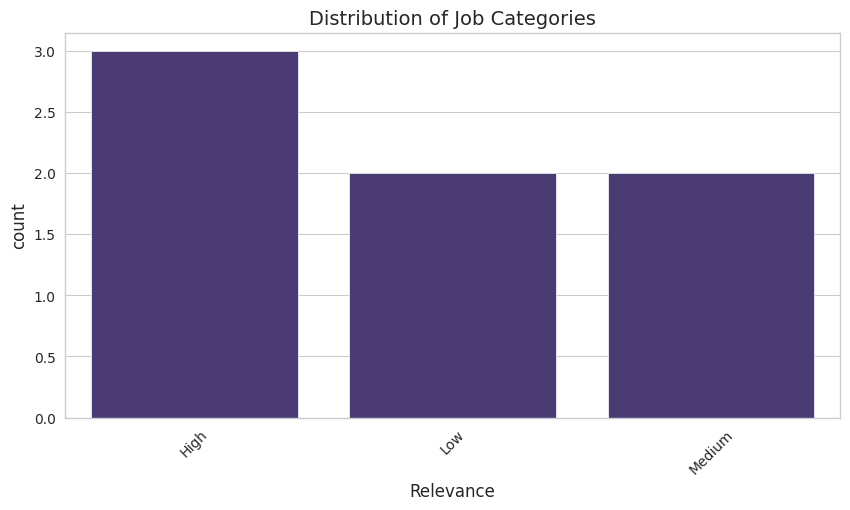


📏 TEXT LENGTH ANALYSIS


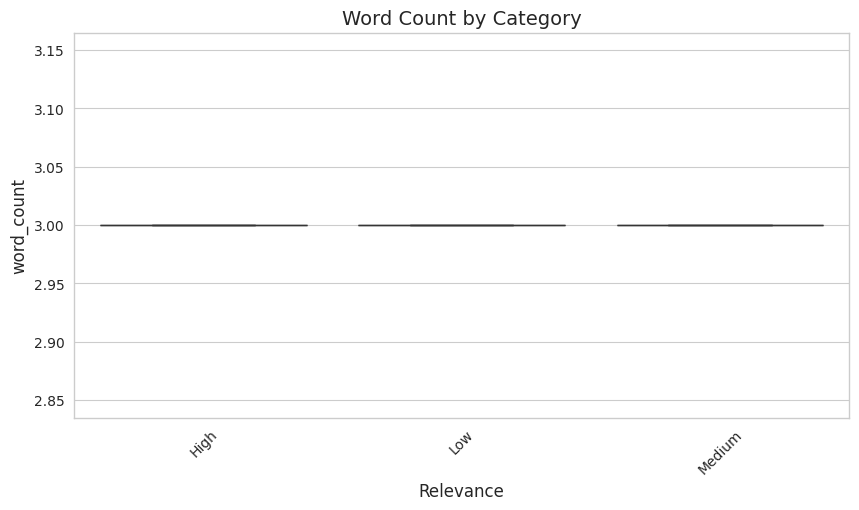

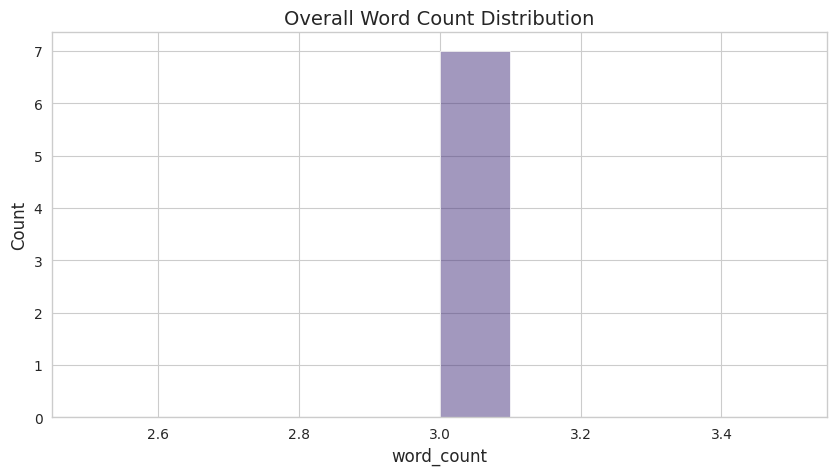


☁️ WORD CLOUD FOR 'High' CATEGORY


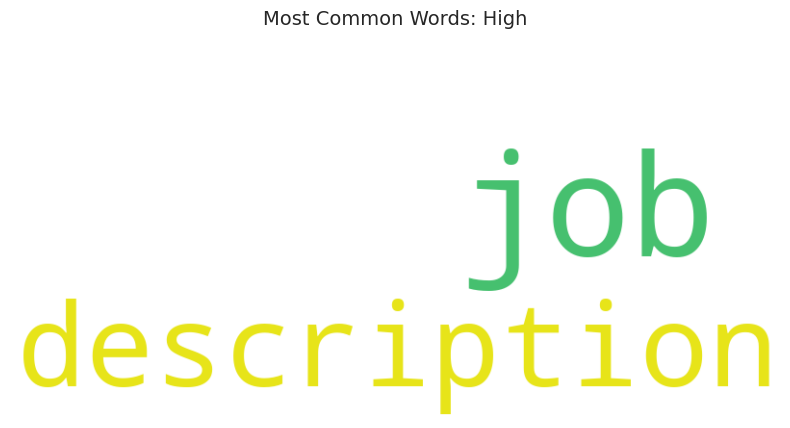


🔑 TOP KEYWORDS BY CATEGORY

Category: High
Top keywords: description, job

Category: Low
Top keywords: description, job

Category: Medium
Top keywords: description, job


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

# Create a simple example DataFrame
data = {
    'Relevance': ['High', 'Low', 'Medium', 'High', 'Low', 'Medium', 'High'],
    'Description': ['Job 1 description', 'Job 2 description', 'Job 3 description',
                    'Job 4 description', 'Job 5 description', 'Job 6 description', 'Job 7 description']
}

df = pd.DataFrame(data)

# Define the column name for the target (Relevance)
target_col = 'Relevance'
text_col = 'Description'

# 1. Simple Target Distribution Plot
print("🎯 TARGET CLASS DISTRIBUTION")
print("="*50)
plt.figure(figsize=(10,5))
ax = sns.countplot(x=target_col, data=df,
                   order=df[target_col].value_counts().index)
plt.title("Distribution of Job Categories", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# 2. Text Length Analysis (Word Count by Category)
print("\n📏 TEXT LENGTH ANALYSIS")
print("="*50)

# Adding word count and character count columns
df['char_count'] = df[text_col].apply(lambda x: len(str(x)))
df['word_count'] = df[text_col].apply(lambda x: len(str(x).split()))

# Boxplot for word count by category
plt.figure(figsize=(10, 5))
sns.boxplot(x=target_col, y='word_count', data=df)
plt.title("Word Count by Category", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Histogram for overall word count distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], bins=10, kde=True)
plt.title("Overall Word Count Distribution", fontsize=14)
plt.show()

# 3. Word Cloud by Category (For "High" category)
print("\n☁️ WORD CLOUD FOR 'High' CATEGORY")
print("="*50)
text = ' '.join(df[df[target_col]=='High'][text_col].apply(lambda x: str(x).lower()))  # Cleaning text
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Most Common Words: High", fontsize=14)
plt.axis('off')
plt.show()

# 4. Top Keywords by Category (Using CountVectorizer)
print("\n🔑 TOP KEYWORDS BY CATEGORY")
print("="*50)

from sklearn.feature_extraction.text import CountVectorizer

for category in df[target_col].unique():
    category_texts = df[df[target_col]==category][text_col].apply(lambda x: str(x).lower())
    cv = CountVectorizer(stop_words='english', max_features=5)  # Limiting to top 5 words
    cv.fit(category_texts)
    top_words = cv.get_feature_names_out()

    print(f"\nCategory: {category}")
    print("Top keywords:", ", ".join(top_words))

